# Almgren-Chriss - Volatility estimation

Suppose we have a lognormal process $X_t = \ln S_t $ where $S_t$ is the stock price:

$$ dX_t = \mu_t dt + \sigma_t dB_t $$.

## 1. Naïve estimator

It is common practice to estimate volatility through a sum of sampled squared returns:

$$ [X,X]_T = \sum_{t_i} (X_{t_{i+1}}-X_{t_i})^2 $$

This estimator relies on the following approximation that the the sum of sampled squared returns converges to the continuous-time volatility:

$$ \lim_{t_i \rightarrow \infty} \sum_{t_i} (X_{t_{i+1}}-X_{t_i})^2 = \int_{0}^T \sigma_t^2 dt $$

We implement this in Python:

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def lognormal_process(M=1000, sigma=0.1, nb_sims=10, T=1.0, S0=100, mu=0.1):
    
    # Initialization
    dt = T/M
    
    # Stock price diffusion
    z1 = np.random.randn(M+1, nb_sims)
    S = np.zeros((M+1, nb_sims))
    S[0] = S0
    
    for t in range(1,M+1):
        S[t] = S[t-1] * np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z1[t])
    
    # Returns
    R = np.zeros((M+1, nb_sims))

    for i in range(nb_sims):
        for t in range(len(R)):
            R[t] = S[t]/S[t-1] - 1
    
    return S, R


def heston_process(M=1000, r=0.3, sigma=0.25, sims_process=10, T=1.0, S0=100, a0=0.2,
                   rho=-0.5, gamma=0.5, kappa=3.0, mu=0.25):
    # Initialization
    dt = T/M
    ah = np.zeros((M+1,sims_process))
    a = np.zeros_like(ah)
    ah[0] = a0
    a[0] = a0
    
    S = np.zeros((M+1, sims_process))
    S[0] = S0
    
    # Volatility diffusion
    z1 = np.random.randn(M+1,sims_process)
    z2 = rho*z1 + np.sqrt(1-rho**2)*np.random.randn(M+1,sims_process)

    for t in range(1, M+1):
        ah[t] = (ah[t-1] + kappa*(mu - np.maximum(ah[t-1],0))*dt +
                 sigma * np.sqrt(dt) * np.sqrt(np.maximum(ah[t-1],0)) * z1[t])
        a = np.maximum(ah, 0)
    
    # Stock price diffusion
    for t in range(1,M+1):
        # Stock
        S[t] = S[t-1] * np.exp((r-0.5*sigma**2)*dt + np.sqrt(dt) * np.sqrt(a[t]) * z2[t])
    
    # Returns
    R = np.zeros((M+1, sims_process))

    for i in range(sims_process):
        for t in range(1,len(R)):
            R[t] = S[t]/S[t-1] - 1
    
    return S, R

In [2]:
# S, R = lognormal_process(M=100000-1)
S, R = heston_process(M=100000-1)

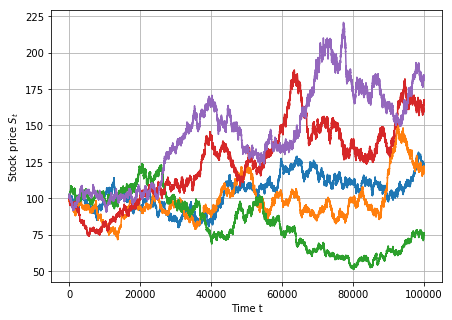

In [3]:
plt.figure(figsize=(7,5))
plt.plot(S[:,0:5])
plt.grid(True)
plt.xlabel('Time t')
plt.ylabel('Stock price $S_t$')
plt.show()

In [13]:
# Naive estimator
vol_naive = []

for m in range(R.shape[1]):
    vol_naive.append(np.std(R[:,m]) * np.sqrt(252))

vol_naive

[0.025390060477009136,
 0.025988452211642948,
 0.03132392196807509,
 0.032502109455013063,
 0.033122095907841091,
 0.026641040453827758,
 0.025627453101609615,
 0.027963856240578636,
 0.029733671476129774,
 0.026308502997066163]

According to Zhang, Mykland and Aït-Sahalia (2005), this approach only works for extremely high sampling frequences and is inconsistent with real-world market microstructure where return time series are sampled at multiple tick sizes. We thus need to correct for microstructure biases (not taking into account the existence of a bid-ask spread for example).

## 2. ZMA estimator

A common approach among researchers who wish to correct microstructure biases is to choose lower sampling frequencies. But this approach might lead to discaring large amounts of data. For Zhang, Mykland and Aït-Sahalia (2005), reducing sampling frequency is not sufficient to correct for microstructure biases, it merely increases its impact on volatility estimation.

One model-free solution proposed by Zhang, Mykland and Aït-Sahalia (2005) is to consider returns as an unobservable $X_t$ latent variable and $Y_t$ our best estimation of the latent returns.

$$ Y_{t_i} = X_{t_i} + \varepsilon_{t_i} $$

ZMA offer 5 possible estimators to implement:

1. *Naïve estimator*
2. *Lower frequency estimator*
3. *Optimal lower frequency estimator*
4. *Average of subsampled estimators*
5. *Average of subsampled estimators + Naïve estimator*

We will focus on their "first-best approach" (the 5th). We start by computing the naïve estimator:

$$ [Y,Y]_T^{(all)} = \sum_{i=1}^N (Y_{t_{i+1}}-Y_{t_i})^2 $$

with $N$ the number of observation of our data sample over all period $T$. Since $[Y,Y]_T^{(all)}$ is prone to market microstructure biases but at the same time it is hard to find the optimal sampling frequency for the volatility estimator. One solution proposed by ZMA is to average estimators $[Y,Y]_T^{(k)}$ across $K$ grids of average size $\bar n$, given by $[Y,Y]_T^{(avg)}$:

$$ [Y,Y]_T^{(avg)} = \frac{1}{K} \sum_{k=1}^K [Y,Y]_T^{(k)} $$

The "first-best approach" combines both the **naïve estimator** $[Y,Y]_T^{(all)}$ and the **average of subsampled estimators** $[Y,Y]_T^{(avg)}$, and gives an estimation of the latent $X_{t}$ process:

$$ \hat{[X,X]_T} = [Y,Y]_T^{(avg)} - \frac{\bar n}{n} [Y,Y]_T^{(all)} $$

where $n$ is the number of observations, $\bar n$ is the subsample size of a grid (which we get through $\bar n = \frac{n}{K} $) and $K = cn^{2/3}$ is the number of grids with $c = (\frac{T}{12(E\varepsilon^2)^2} \int_0^T \sigma_t^4 dt)^{-1/3}$.

Finally, we compute the adjusted estimator:

$$ \hat{[X,X]_T}^{(adj)} = (1 - \frac{\bar n}{n})^{-1} \hat{[X,X]_T}   $$

In [2]:
# S, R = lognormal_process(M=100000-1, sigma=0.4, mu=0.4)
S, R = heston_process(M=100000-1, sims_process=1, sigma=0.8, r=0.1)

In [142]:
# Number of grids (K)
T = 1.0
n = S.shape[0]
c = 0.05
# c = (T/12.0 *) ** (-1.0/3.0)  Computing the c parameter seems complicated
K = c * n ** (2/3)
K = int(K)
K

107

In [143]:
# Subsample size
n_bar = n / K
n_bar

934.5794392523364

In [144]:
K * n_bar

100000.0

We start by computing:

$$ [Y,Y]_T^{(avg)} = \frac{1}{K} \sum_{k=1}^K [Y,Y]_T^{(k)} $$

In [145]:
# Average of subsampled estimators (k)
ret = R[:,0]

def split_seq(seq, size):
        newseq = []
        splitsize = 1.0/size*len(seq)
        for i in range(size):
                newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
        return newseq

ret_ks = split_seq(ret, K)
len(ret_ks)

107

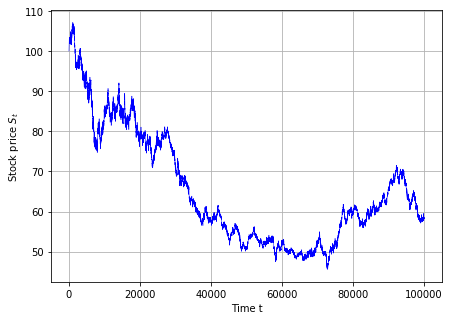

In [146]:
plt.figure(figsize=(7,5))
plt.plot(S[:,0], color='blue', lw=0.5)
plt.grid(True)
plt.xlabel('Time t')
plt.ylabel('Stock price $S_t$')
plt.show()

In [147]:
vol_ks = []
for ret_k in ret_ks:
    vol_k = np.std(ret_k)
    vol_ks.append(vol_k)

In [148]:
len(vol_ks)

107

In [149]:
vol_average = np.mean(vol_ks)
vol_average * np.sqrt(252)

0.024160927775558703

In [150]:
round(vol_average * np.sqrt(252), 2)

0.02

We compute the naïve estimator:

$$ [Y,Y]_T^{(avg)} = \frac{1}{K} \sum_{k=1}^K [Y,Y]_T^{(k)} $$

In [151]:
vol_naive = np.std(ret)
vol_naive * np.sqrt(252)

0.041804342922760022

Thus, we get:

$$ \hat{[X,X]_T} = [Y,Y]_T^{(avg)} - \frac{\bar n}{n} [Y,Y]_T^{(all)} $$

$$ \hat{[X,X]_T}^{(adj)} = (1 - \frac{\bar n}{n})^{-1} \hat{[X,X]_T}   $$

In [152]:
vol = vol_average - n_bar/n * vol_naive
vol_adj = (1 - n_bar/n)**(-1) * vol
vol_adj * np.sqrt(252)

0.023994480462849261

In [153]:
def ZMA_estimator(R):
    """
    Zhang, Mykland & Aït-Sahalia (adjusted) volatility estimator
    """
    # Initialization
    n = R.shape[0]
    c = 0.05   # This needs to be changed: formula is very complex
    K = c * n ** (2/3)
    K = int(K)
    n_bar = n / K
    
    # Partition
    def split_seq(seq, size):
        newseq = []
        splitsize = 1.0/size*len(seq)
        for i in range(size):
                newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
        return newseq
    
    ret_ks = split_seq(R, K)
    # print(K)
    
    # Compute vol_k for the entire partition and vol_average
    vol_ks = []
    for ret_k in ret_ks:
        vol_k = np.std(ret_k)
        vol_ks.append(vol_k)
    
    vol_average = np.mean(vol_ks)
    
    # Compute ZMA estimator
    vol = vol_average - n_bar/n * vol_naive
    vol_adj = (1 - n_bar/n)**(-1) * vol
    
    return vol_adj

In [154]:
ZMA_estimator(ret) * np.sqrt(252)

0.023994480462849261

We should test this on a rolling window basis:

In [155]:
i = -1
results_zma = []
results_naive = []

while 10000 + i < len(ret):
    
    i = i + 1
    
    # Returns
    temp_R = ret[0+i:10000+i]
    
    # ZMA estimator
    results_zma.append(ZMA_estimator(temp_R))
    
    # Naive estimator
    results_naive.append(np.std(temp_R))

In [156]:
results_naive[1:10]

[0.0017521683984159642,
 0.0017521879381702031,
 0.0017522711185555229,
 0.0017522531251503595,
 0.0017522240741214799,
 0.0017523507319258038,
 0.0017522724068354807,
 0.0017522454497793678,
 0.0017522355005329866]

In [157]:
results_zma[1:10]

[0.0016726446877615565,
 0.0016726523961943956,
 0.0016726961325315209,
 0.0016726312886745757,
 0.0016724693960325353,
 0.0016727436007189507,
 0.0016726633072692385,
 0.0016727725171151247,
 0.0016727710296522503]

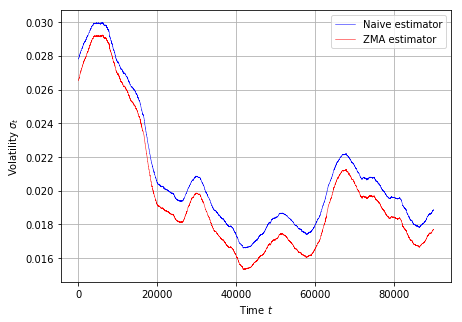

In [158]:
naive = np.array(results_naive[1:]) * np.sqrt(252)
zma = np.array(results_zma[1:]) * np.sqrt(252)

plt.figure(figsize=(7,5))
plt.plot(naive, color='blue', label='Naive estimator', lw=0.5)
plt.plot(zma, color='red', label='ZMA estimator', lw=0.5)
plt.xlabel('Time $t$')
plt.ylabel('Volatility $\sigma_t$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [159]:
ZMA_estimator(ret[1:10000])

0.0016727782104891298

In [160]:
ZMA_estimator(ret[10000:20000])

0.0016961591361209368

## 3. Garman-Klass estimator

There are different methods of calculating volatility using some or all of the open (O), high (H), low (L) and close (C). The Garman-Klass estimator is an extension of Parkinson which includes opening and closing prices (if opening prices are not available the close from the previous day can be used instead).

$$ \sigma_{GK} = \sqrt{\frac{F}{N}} \sqrt{\sum_{i=1}^{N} [ln(\frac{h_i}{l_i})^2 - 2\ln(2) \ln(\frac{c_i}{o_i})^2 ]} $$

In [ ]:
def garman_klass(x):
    """
    Garman-Klass volatility estimator. Requires dataframe with Open, High, Low and Close prices.
    """
    log_hl = (x['High'] / x['Low']).apply(np.log)
    log_cc = (x['Close'] / x['Close'].shift(1)).apply(np.log)
    ans = log_hl**2 - (2*math.log(2)-1) * log_cc**2
    return ans

## 4. Application

In [48]:
import pandas as pd

data = pd.read_excel('data.xlsx', sheet='1_min_IBM')
data1 = pd.read_excel('data.xlsx', sheet='10_min_FP', header=0, index_col=0)
data2 = pd.read_excel('data.xlsx', sheet='5_min_FP', header=0, index_col=0)
data3 = pd.read_excel('data.xlsx', sheet='1_min_FP', header=0, index_col=0)

In [56]:
data.head()

,Dates,Open,Close,High,Low,Value,Volume
0,2018-03-01 09:00:00,46.630,46.725,46.80,46.575,12749083.0,273207
1,2018-03-01 09:10:00,46.725,46.625,46.75,46.620,4258218.5,91205
2,2018-03-01 09:20:00,46.620,46.650,46.71,46.615,5145786.5,110272
3,2018-03-01 09:30:00,46.650,46.775,46.82,46.620,4698093.0,100565
4,2018-03-01 09:40:00,46.770,46.755,46.83,46.750,3548564.5,75852
